## Optional: Step 6a of stellar halo pipeline

This notebook is designed to allow the user to check the results of steps 1-5 of the stellar halo pipeline and, in combination with FixHostIDs, amend the allhalostardata hdf5 file as needed. The general idea is to visually inspect all of the star particles that have been assigned to a particular host and either make sure that that assignment makes sense or reassign them. Incorrect assignments often happen during mergers, particularly if the halo finder loses track of the smaller ha
lo before it ceases star formation. I typically use it for at least the following:

1. Attempt to identify the hosts of any star particles that didn't get assigned one during the earlier steps of the pipeline (i.e., those with StepIndex_0 as a host_ID in the allhalostardata hdf5 file). These are most common in the very first snapshot and, in that case, typically formed in halos that started merging before the first snapshot was saved. However, it's typically clear which ones should go together, because there will be individual clumps. I save the IDs of star particles that appear to go together and give them an id of Step_-n (n=1,2,3...) to make it clear that these particles formed in the same location, but do not belong to a halo that can be traced backwards.

2. Check that star particles assigned to the same halo actually make up a coherent structure. I typically start by visualizing the particles belonging to each host_ID at the snapshot when that halo was last identified to make sure that this is a single entity. If the halo has already started to disrupt, I will back up until I find the last snapshot where it was a coherent structure and make sure all of the star particles assigned to it make sense. If necessary, I will go through each snapshot and make sure that each star particle that formed between this snapshot and the last one that was assigned to this halo actually appear to have formed there. Even amiga sometimes gets confused during mergers and will assign star particles to the wrong host.

3. Check that every star particle that is assigned to the central galaxy is actually an in situ star particle. This is really an extension of 2, but for the main halo I always walk through every single snapshot and just look at the star particles that have formed since the last snapshot and have been assigned to the main halo. It is fairly common to see star particles that clearly formed in a disrupting satellite get assigned to the host because the halo finder has lost track of the satellite.

If you end up needing to reassign quite a few star particles, it may be helpful to hop over to FixHostIDs to do so and then come back here and load in your updated allhalostardata hdf5 file.

In [4]:
%matplotlib inline
import os
os.environ['TANGOS_SIMULATION_FOLDER'] = '/home/selvani/MAP/Sims/cptmarvel.cosmo25cmb/cptmarvel.cosmo25cmb.4096g5HbwK1BH/'
# os.environ['TANGOS_DB_CONNECTION'] = '/home/selvani/MAP/Data/Marvel_BN_N10.db'
os.environ['TANGOS_DB_CONNECTION'] = '/home/selvani/MAP/pynbody/Tangos/Marvel_BN_N10.db'
os.chdir('/home/selvani/MAP/pynbody/AnnaWright_startrace/')

import pynbody
import numpy as np
import h5py
import math
import tangos as db
import matplotlib.pyplot as plt
from IPython.display import Audio
import glob
from pynbody.array import SimArray
import IonUtils

In [217]:
# halo = 'r614' # Which simulation is this?

simpath = '/home/selvani/MAP/Sims/cptmarvel.cosmo25cmb/cptmarvel.cosmo25cmb.4096g5HbwK1BH/'
sims = 'cptmarvel.cosmo25cmb.4096g5HbwK1BH'

ss_dir = 'cptmarvel.4096g5HbwK1BH_bn'
sim_base = simpath + ss_dir + '/'
ss_z0 = sim_base + sims + '.004096'

odir = "/home/selvani/MAP/pynbody/stellarhalo_trace_aw/"

sim = db.get_simulation(ss_dir)
# odir = '/Users/Anna/Research/Outputs/M33Analogs/MM/'+halo+'/'
# simpath = '/Volumes/Audiobooks/RomZooms/'


relhostid = np.array(['4096_2']) # Which star particle host_IDs do you want to see? This can be a single host_ID or a list
# For instance, if you wanted to see all star particles that weren't assigned a host, you could do the below
# relhostid = []
# for i in range (0,len(sim.timesteps)):
#     relhostid.append(str(i).zfill(4)+'_0')
# relhostid = np.array(relhostid)
print('relhostid = ', relhostid)

st = 1408 # Which snapshot do you want to visualize these star particles at?
tslim = 1331 # What is the earliest snapshot that you want the star particles to have formed at?
    # tslim = st-96 # This is the standard MM spacing, so this would give you any star particles that formed since last snapshot
ishalo = 2 # Which halo do you want to center on? If this is 0, we will center on the first star particles with relhostid


relhostid =  ['4096_2']


In [218]:
# This is mostly a sanity check and can be useful for later steps. 
# It tells you the index of the snapshot you're looking at in the tangos database
dbind_lim = 0
for ctr,ts in enumerate(sim.timesteps):
    if str(st).zfill(6) in str(ts):
        dbind = ctr
    if str(tslim).zfill(6) in str(ts):
        dbind_lim = ctr
print ('Database index: ',dbind)

Database index:  15


In [219]:
# Read in your data
with h5py.File(odir+'/'+sims+'_allhalostardata.h5','r') as f:
    hostids = f['host_IDs'].asstr()[:] # unique host IDs
    partids = f['particle_IDs'][:] # iords
    pct = f['particle_creation_times'][:] # formation times
    ph = f['particle_hosts'][:] # local host IDs (i.e., host at formation time)
    pp = f['particle_positions'][:] # position at formation time
    tsloc = f['timestep_location'][:] # snapshot where star particle first appears
uIDs = np.unique(hostids)

In [220]:
print(pct)

[1.29810826 1.29810826 1.29810826 ... 9.44362535 9.44362535 9.44362535]


In [221]:
# Calculate the times corresponding to the limits you specified earlier and ID the star particles that formed
# between these times and were assigned to relhostid
uplim = sim[dbind].time_gyr
if tslim>0:
    lowlim = sim[dbind_lim].time_gyr-0.001
elif tslim == 0:
    lowlim = 0
else:
    print ('Please rethink your lowlim value. It does not make sense.')
pids = partids[(np.isin(hostids,relhostid)) & (pct>lowlim) & (pct<uplim)]

print ('Relevant particles:',len(pids)) # How many star particles will actually be highlighted?

Relevant particles: 869


In [29]:
def HighlightParticles(s, cen, rad=2, projax='x', show_hs=True, ret='relstars',
                      savefig=False, thread=True, haloplot=True):
    '''
    Primary workhorse of this notebook
    Creates two figures:
    1. a gas density image using all particles within rad kpc of cen and projected along the projax axis.
       Any stars that formed during the relevant time period (i.e., between tslim and st) and were assigned
       to the relevant halo(s) (relhostid) will be shown as green dots. If show_hs=True, other star particles in this
       region will also be shown in cyan. This often helps to highlight when incorrect halo assignments have been made
       (e.g., if a bunch of green stars are in a separate clump away from the other green stars and are clearly centered
       on a clump of cyan stars). If savefig=True, this will be saved.
    2. a bar graph showing the numbers of stars in this region that have been assigned to different hosts - another way to 
       potentially identify incorrect halo assignments. This bit will also print out every unique host ID with at least one
       star in this region assigned to it so and the number of stars assigned to it.
    If ret='relstars',returns the list of stars in this region that formed between tslim and st and were assigned to relhostid so that, 1) You
    can check these off the list and look for any errant particles that formed during this time and were assigned to this host
    but are not in this region and 2) if you want to reassign them with FixHostID, you can save them to a numpy file and do so.
    If ret is set to anything else, it will return the full list of stars in the region.
    The "thread" argument is purely for debugging. Set this to False to debug if pynbody barfs. Most often, what you need to
    do is increase the size of the region you're imaging because there are too few gas particles in your currently specified region.
    '''
    import matplotlib.patches as mpatches

    sp = s[pynbody.filt.Sphere(SimArray([rad], "kpc"), cen)].load_copy() # only show particles in the specified sphere
    sp.physical_units()
    ns = len(sp.s)
    if ns > 0:  # make sure the sphere actually contains some stars
        # Construct star and gas image
        rel2 = np.isin(sp.s['iord'], pids)
        print(len(sp.s['iord'][rel2]), 'relevant stars found')
        tx = None
        sp['pos'] -= cen
        if projax == 'y':
            sp.rotate_x(90)
        elif projax == 'z':
            sp.rotate_y(90)
        elif projax == 'faceon':
            tx = pynbody.analysis.angmom.faceon(sp)
        elif projax == 'sideon':
            tx = pynbody.analysis.angmom.sideon(sp)
        pynbody.plot.sph.image(
            sp.g, qty="rho", units="Msol pc**-2", width=2*rad,
            vmin=10**-3, vmax=10**3, cmap="plasma", threaded=thread
        )
        if show_hs:
            plt.plot(
                sp.s['pos'][:, 0], sp.s['pos'][:, 1],
                markersize=1.0, color='cyan', marker='o', alpha=0.1, linestyle='none')
        plt.plot(
            sp.s['pos'][rel2][:, 0], sp.s['pos'][rel2][:, 1],
            markersize=2.0, color='green', marker='o', alpha=0.5, linestyle='none')

        if haloplot:
            # --- HALO CIRCLE OVERLAY ---
            all_halos = db.get_timestep(ss_dir+'/%'+str(st)).halos.all()
            all_halos = [halo for halo in all_halos if halo.NStar > 0]
            # cut by location
            halos = []
            for halo in all_halos:
                try:
                    if np.linalg.norm(np.array(halo['shrink_center']) - cen) < rad:
                        halos.append(halo)
                except Exception as e:
                    print(f"Could not process halo {halo.halo_number}: {e}")
            print('Found', len(halos), 'halos with stars')
            if halos is not None:
                print(halos)
                for halo in halos:
                    try:
                        # Get halo center and Rvir, shift to plotting coordinates
                        rvir = float(halo['Rvir'])  # in kpc
                        # Get halo center and shift to plotting coordinates
                        hcen = np.array(halo['shrink_center']) - cen

                        # Apply the SAME rotation that was applied to particles
                        if projax == 'y':
                            # Apply 90-degree rotation around x-axis
                            hcen = np.array([hcen[0], -hcen[2], hcen[1]])
                        elif projax == 'z':
                            # Apply 90-degree rotation around y-axis  
                            hcen = np.array([hcen[2], hcen[1], -hcen[0]])
                        elif projax == 'faceon' or projax == 'sideon':
                            if tx is not None and hasattr(tx, 'matrix'):
                                # Apply the transformation matrix to the halo center
                                transform_matrix = tx.matrix
                                print('Applying transformation matrix')
                                hcen = np.dot(transform_matrix, hcen)

                        # Now project to 2D (always use x,y after proper rotation)
                        x, y = hcen[0], hcen[1]

                        circle = mpatches.Circle(
                            (x, y), rvir, edgecolor='white', facecolor='none', lw=0.75, alpha=0.7)
                        plt.gca().add_patch(circle)
                    except Exception as e:
                        print(f"Could not plot halo {halo.halo_number}: {e}")


        if savefig:
            plt.savefig(odir + 'stars_' + str(tslim).zfill(4) + '_' + str(st).zfill(4) +
                        '_' + projax + '.png', dpi=150)
        plt.show()

        # Construct bar plot
        spstars = sp.s['iord']
        relhalo = np.isin(partids, spstars)
        cat = []
        num = []
        for hival in np.unique(hostids[relhalo]):
            cat.append(hival)
            ct = np.count_nonzero(hostids[relhalo] == hival)
            print(hival, ct)
            num.append(ct)
        plt.figure(figsize=(12, 9))
        plt.bar(cat, num)
        plt.show()
        bb = cat[np.argmax(num)]
        print('likely host:', bb)  # host with the most stars in this region
    else:
        print('No stars in this sphere!')
        rel2 = np.array([])
    if ret == 'relstars':
        return sp.s['iord'][rel2]
    else:
        return sp.s['iord']

In [10]:
def HighlightParticlesMultiProjection(s, cen, rad=2, show_hs=True, ret='relstars',
                                    savefig=False, thread=True, haloplot=True, figsize=(24, 6), caption=None, overwrite=True):
    '''
    Creates x, y, and z projections and a host assignment bar plot in a single 1x4 figure.
    
    Parameters:
    -----------
    s : pynbody snapshot
        The simulation snapshot
    cen : array-like
        Center position for the sphere [x, y, z] in kpc
    rad : float, default=2
        Radius of the sphere in kpc
    show_hs : bool, default=True
        Whether to show other star particles in cyan
    ret : str, default='relstars'
        Return type - 'relstars' for relevant stars only, else all stars
    savefig : bool, default=False
        Whether to save the figure
    thread : bool, default=True
        Whether to use threading for image generation
    haloplot : bool, default=True
        Whether to overlay halo circles
    figsize : tuple, default=(24, 6)
        Figure size for the 1x4 subplot
    caption : str, optional
        Caption to add to the figure

    Returns:
    --------
    list : Star particle IDs based on ret parameter
    '''
    import os
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from pynbody.array import SimArray
    
    if savefig:
        # Ensure the output directory exists
        save_dir = os.path.join(odir, 'plots')
        os.makedirs(save_dir, exist_ok=True)
        # Use a more descriptive filename
        save_path = os.path.join(save_dir, f"stars_{caption}_projections_HI.png")
        if os.path.exists(save_path) and not overwrite:
            print(f"File {save_path} already exists. Skipping.")
            return 1

    # Create the sphere and load data
    sp = s[pynbody.filt.Sphere(SimArray([rad], "kpc"), cen)].load_copy()
    sp.physical_units()
    print('Calculating gas mass...')
    IonUtils.calculate_gas_mass(sp)
    print('Calculating gas densities...')
    IonUtils.calculate_gas_rhos(sp)
    ns = len(sp.s)
    
    if ns > 0:
        # Identify relevant stars
        rel2 = np.isin(sp.s['iord'], pids)
        print(f"{len(sp.s['iord'][rel2])} relevant stars found")
        
        # --- Calculate data for bar plot ahead of time ---
        spstars = sp.s['iord']
        relhalo = np.isin(partids, spstars)
        cat = []
        num = []
        if np.any(relhalo):
            unique_hosts, counts = np.unique(hostids[relhalo], return_counts=True)
            for hival, ct in zip(unique_hosts, counts):
                cat.append(str(hival)) # Ensure category labels are strings
                num.append(ct)
            
            if cat:
                bb = cat[np.argmax(num)]
                print('Likely host:', bb)
        
        # Store original positions before any modifications
        original_pos = sp['pos'].copy()
        
        # Create figure with 1x4 subplots
        fig, axes = plt.subplots(1, 4, figsize=figsize)
        projections = ['x', 'y', 'z']
        titles = ['X Projection (Y-Z plane)', 'Y Projection (X-Z plane)', 'Z Projection (X-Y plane)']
        
        # Add the main caption (suptitle) if provided
        if caption:
            fig.suptitle('Halo {}'.format(caption), fontsize=16)

        if haloplot:
            # --- HALO CIRCLE OVERLAY ---
            all_halos = db.get_timestep(ss_dir+'/%'+str(st)).halos.all()
            all_halos = [halo for halo in all_halos if halo.NStar > 0]
            # cut by location
            halos = []
            for halo in all_halos:
                try:
                    if np.linalg.norm(np.array(halo['shrink_center']) - cen) < rad:
                        halos.append(halo)
                except Exception as e:
                    print(f"Could not process halo {halo.halo_number}: {e}")
            print('Found', len(halos), 'halos with stars')
            if halos is not None:
                # distinguishable_colors = [
                #         '#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                #         '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', 
                #         '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', 
                #         '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9'
                # ]
                halo_colors = {}
                cmap = plt.get_cmap('Set3', len(halos))
                for i, halo in enumerate(halos):
                    halo_colors[halo.halo_number] = cmap(i)
                print(halos)

        # --- Plotting the three projections on the first 3 axes ---
        for i, (ax, projax, title) in enumerate(zip(axes[:3], projections, titles)):
            # Reset positions and apply centering for each projection
            sp['pos'] = original_pos.copy()
            sp['pos'] -= cen
            
            # Apply rotations for different projections
            if projax == 'y':
                sp.rotate_x(90)
            elif projax == 'z':
                sp.rotate_y(90)
            
            # Create gas density image
            pynbody.plot.sph.image(
                sp.gas, qty="HI_rho", units="Msol pc**-2", width=2*rad,
                vmin=10**-3, vmax=10**3, cmap="plasma", threaded=thread,
                axes=ax
            )
            
            # Plot star particles
            if show_hs:
                ax.plot(
                    sp.s['pos'][:, 0], sp.s['pos'][:, 1],
                    markersize=1.0, color='cyan', marker='o', alpha=0.1, linestyle='none',
                    label='Other stars'
                )
            
            ax.plot(
                sp.s['pos'][rel2][:, 0], sp.s['pos'][rel2][:, 1],
                markersize=2.0, color='green', marker='o', alpha=0.25, linestyle='none',
                label='Relevant stars'
            )
            
            # Add halo circles if requested
            if haloplot:
                if halos is not None:
                    for halo in halos:
                        try:
                            # Get halo center and Rvir, shift to plotting coordinates
                            try:
                                rvir = float(halo['Rvir'])  # in kpc
                            except Exception as e:
                                rvir = float(halo['max_radius'])
                            # Get halo center and shift to plotting coordinates
                            hcen = np.array(halo['shrink_center']) - cen

                            # Apply the SAME rotation that was applied to particles
                            if projax == 'y':
                                # Apply 90-degree rotation around x-axis
                                hcen = np.array([hcen[0], -hcen[2], hcen[1]])
                            elif projax == 'z':
                                # Apply 90-degree rotation around y-axis  
                                hcen = np.array([hcen[2], hcen[1], -hcen[0]])

                            # Now project to 2D (always use x,y after proper rotation)
                            x, y = hcen[0], hcen[1]

                            circle = mpatches.Circle(
                                (x, y), rvir, edgecolor=halo_colors[halo.halo_number], facecolor='none', lw=0.75, alpha=1,
                                label=f'Halo {halo.halo_number}'
                            )
                            ax.add_patch(circle)
                            circle.set_clip_path(ax.patch)
                        except Exception as e:
                            print(f"Could not plot halo {halo.halo_number}: {e}")

            
            # Set title and labels
            ax.set_title(title, fontsize=12)
            
            # Add legend to first subplot
            if i == 0 and (show_hs or len(sp.s['iord'][rel2]) > 0):
                ax.legend(loc='upper right', fontsize=8)

        # --- Construct bar plot on the 4th subplot ---
        ax4 = axes[3]
        if len(cat) > 0:
            ax4.bar(cat, num)
            ax4.set_ylabel('Number of Stars')
            ax4.set_title('Star Particle Host Assignments')
            ax4.tick_params(axis='x', labelrotation=90, labelsize=8)
        else:
            ax4.text(0.5, 0.5, 'No host assignments found', ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Star Particle Host Assignments')
            ax4.set_xticks([])
            ax4.set_yticks([])

        plt.tight_layout()
        
        # Adjust layout if a caption is present to prevent it from overlapping
        if caption:
            plt.subplots_adjust(top=0.88)

        if savefig:
            # Ensure the output directory exists
            save_dir = os.path.join(odir, 'plots')
            os.makedirs(save_dir, exist_ok=True)
            # Use a more descriptive filename
            save_path = os.path.join(save_dir, f"stars_{caption}_projections_HI.png")
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Figure saved to {save_path}")
        plt.show()
        
    else:
        print('No stars in this sphere!')
        rel2 = np.array([])
        return np.array([])
    
    if ret == 'relstars':
        return sp.s['iord'][rel2]
    else:
        return sp.s['iord']

### Old

In [222]:
fpath = sim_base + sims + '.' +str(1408).zfill(6) 
print(fpath)
s = pynbody.load(fpath)

/home/selvani/MAP/Sims/cptmarvel.cosmo25cmb/cptmarvel.cosmo25cmb.4096g5HbwK1BH/cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.001408


In [223]:
s.physical_units()
h = s.halos(halo_numbers='v1')
# print(h)

pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


In [224]:
all_halos = db.get_timestep(ss_dir+'/%'+str(st)).halos.all()
halos = [halo for halo in all_halos if halo.NStar > 0]
print('Found', len(halos), 'halos with stars')
print(halos[1].halo_number)

Found 19 halos with stars
2


In [225]:
relstars = np.isin(s.s['iord'],pids) # which relevant stars actually exist at this snapshot?

In [73]:
# Center on relevant area
if ishalo == 0:
    roughcen = s.s['pos'][relstars][0] # center on first relevant star particle
else:
    hind = sim[dbind][ishalo].halo_number # center on median position of particles in ishalo
    hhindpos = h[hind]['pos']
    print('hhindpos = ', hhindpos)
    roughcen = np.median(hhindpos,axis=0)
roughcen

hhindpos =  [[367.41071486  99.54865317 671.07554929]
 [367.82199852  85.67032732 625.35876551]
 [381.71766884 112.98813506 652.1098762 ]
 ...
 [411.33855206 129.85480051 597.11133977]
 [424.67975881 162.93036682 603.71069352]
 [407.79520195 111.51315113 592.44746714]]


array([375.73494888, 137.32062968, 659.31680864])

In [74]:
roughcen

array([375.73494888, 137.32062968, 659.31680864])

In [231]:
halo = db.get_timestep(ss_dir+'/%'+str(st)).halos.all()[1]
roughcen = halo['shrink_center'] # Get the center of the halo we're looking at

In [232]:
halo

<Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.001408/halo_2' | NDM=953526 Nstar=23447 Ngas=420817>

In [233]:
roughcen += (3, -1.5, 2)
# roughcen += (-2.5, -0.5, -4)

#### Automate spike finding

In [39]:
valout = np.max(np.power(np.sum(np.pow(s.s['pos'][relstars]-roughcen, 2), axis=1), 1/2))
print(valout)
print(valout.shape)

736.9774750212791
()


In [88]:
counts, x_edges = np.histogram(s.s['x'][relstars],range=[-25000,25000],bins=500)
x = x_edges[:-1] + np.diff(x_edges) / 2  # Get the bin 
import scipy.signal
peaks = scipy.signal.find_peaks(counts, height=1)
print(x[peaks[0]]-roughcen[0]) # take average y value of stars <200kpc to this
final_x = x[peaks[0]]

[  24.18108585 2524.18108585]


In [94]:
# Vectorized approach for calculating final_y values
final_y = []
final_z = []
buffer = 200

for x_peak in final_x:
    # Create boolean mask for stars within 200 kpc of this peak
    mask = (s.s['x'][relstars] >= x_peak - buffer) & (s.s['x'][relstars] <= x_peak + buffer)
    
    # Get y coordinates of stars within this range
    y_coords = s.s['y'][relstars][mask]
    z_coords = s.s['z'][relstars][mask]
    
    if len(y_coords) > 0:
        final_y.append(np.mean(y_coords))
    else:
        final_y.append(np.nan)
        print(f"Warning: No stars found near peak at x = {x_peak}")
    if len(z_coords) > 0:
        final_z.append(np.mean(z_coords))
    else:
        final_z.append(np.nan)
        print(f"Warning: No stars found near peak at x = {x_peak}")

final_y = np.array(final_y)
final_z = np.array(final_z)

# Display results
print(f"Peak positions and corresponding y-centers:")
peak_data = np.column_stack([final_x, final_y, final_z])
print(peak_data)

Peak positions and corresponding y-centers:
[[-1950.         -2313.02894748   533.11430873]
 [  550.          -234.83865221  1668.91077787]]


In [ ]:
ids = np.where((s.s['x'][relstars]<final_x[0]+200) & (s.s['x'][relstars]>final_x[0]-200))
final_y = np.mean(s.s['y'][relstars][ids])
final_y

np.float64(-2313.0289474832125)

In [75]:
print(np.min(s['x']))

-12499.998510062174


In [ ]:
SimArray(peak_data[0],units='kpc')

figure out halo ids are assigned
find what amiga assigns halos to
1. figure what halo currently in
2. figure out halo assignments in anna's code

#### Run

Looking for:  869
238 relevant stars found


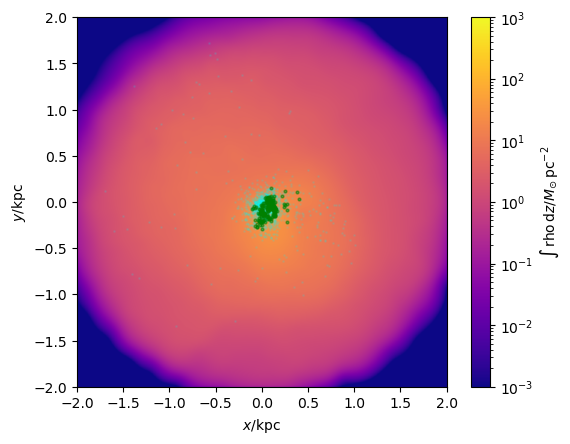

1280_17 1072
4096_2 576


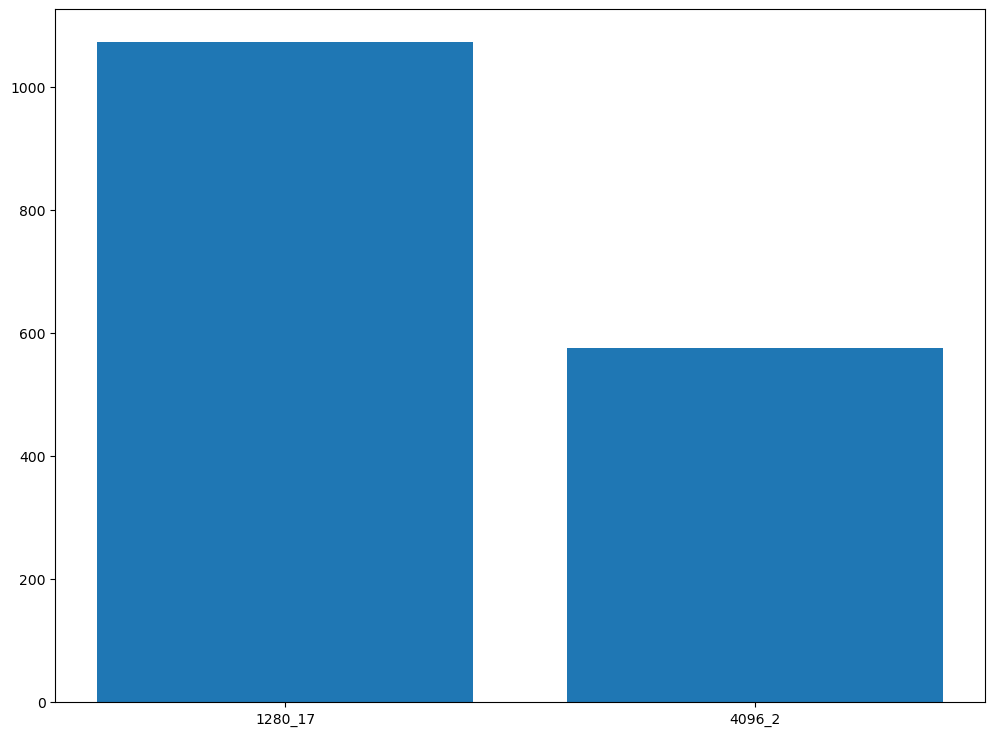

likely host: 1280_17


In [237]:
print ('Looking for: ', len(pids)) # Full number of relevant star particles in this snapshot.
                                   # Make sure you actually find all of them!
fst = HighlightParticles(s,roughcen,rad=2,projax='z',haloplot=False, show_hs=True) # Have our first look 

### Routine for Visualizing and Saving Every Star-Forming Halo

In [11]:
all_timesteps = db.get_simulation("cptmarvel.4096g5HbwK1BH_bn").timesteps
halos_stars_dict = {}
for timestep in all_timesteps:
    print('Processing timestep:', timestep.extension[-6:])
    halos_stars_dict[timestep.extension[-6:]] = [h for h in timestep.halos.all() if h.NStar > 0]

total_halos = 0
for i, timestep in enumerate(all_timesteps):
    # print(timestep.extension[-6:])
    timestep = timestep.extension[-6:]
    halos = halos_stars_dict[timestep]
    print('\nFound {} halos in timestep {}'.format(len(halos), timestep))
    total_halos += len(halos)
    s = pynbody.load(sim_base + sims + '.' + timestep)
    s.physical_units()

    st = int(timestep) # Which snapshot do you want to visualize these star particles at?
    if not i < 1:
        tslim = int(all_timesteps[i-1].extension[-6:])
        print('Found previous timestep:', tslim)
    else:
        tslim = 0 # What is the earliest snapshot that you want the star particles to have formed at?

    uplim = db.get_timestep("cptmarvel.4096g5HbwK1BH_bn/%" + str(st)).time_gyr
    if tslim>0:
        lowlim = db.get_timestep("cptmarvel.4096g5HbwK1BH_bn/%" + str(tslim)).time_gyr
    elif tslim == 0:
        lowlim = 0
    else:
        print ('Please rethink your lowlim value. It does not make sense.')

print('\nFound {} halos in total'.format(total_halos))

Processing timestep: 000199
Processing timestep: 000291
Processing timestep: 000384
Processing timestep: 000482
Processing timestep: 000512
Processing timestep: 000640
Processing timestep: 000672
Processing timestep: 000768
Processing timestep: 000818
Processing timestep: 000896
Processing timestep: 001025
Processing timestep: 001152
Processing timestep: 001162
Processing timestep: 001280
Processing timestep: 001331
Processing timestep: 001408
Processing timestep: 001536
Processing timestep: 001543
Processing timestep: 001664
Processing timestep: 001792
Processing timestep: 001813
Processing timestep: 001920
Processing timestep: 002048
Processing timestep: 002162
Processing timestep: 002176
Processing timestep: 002304
Processing timestep: 002432
Processing timestep: 002560
Processing timestep: 002624
Processing timestep: 002688
Processing timestep: 002816
Processing timestep: 002944
Processing timestep: 003072
Processing timestep: 003200
Processing timestep: 003245
Processing timestep:

In [ ]:
total_halos = 0
# all_timesteps = all_timesteps[12:]
for i, timestep in enumerate(all_timesteps):
    # print(timestep.extension[-6:])
    timestep = timestep.extension[-6:]
    halos = halos_stars_dict[timestep]
    print('\nFound {} halos in timestep {}'.format(len(halos), timestep))
    total_halos += len(halos)
    s = pynbody.load(sim_base + sims + '.' + timestep)
    s.physical_units()

    st = int(timestep) # Which snapshot do you want to visualize these star particles at?
    if not i < 1:
        tslim = int(all_timesteps[i-1].extension[-6:])
        print('Found previous timestep:', tslim)
    else:
        tslim = 0 # What is the earliest snapshot that you want the star particles to have formed at?

    uplim = db.get_timestep("cptmarvel.4096g5HbwK1BH_bn/%" + str(st)).time_gyr
    if tslim>0:
        lowlim = db.get_timestep("cptmarvel.4096g5HbwK1BH_bn/%" + str(tslim)).time_gyr
    elif tslim == 0:
        lowlim = 0
    else:
        print ('Please rethink your lowlim value. It does not make sense.')

Processing halos:   0%|          | 0/874 [00:00<?, ?it/s]


Found 17 halos in timestep 000199
relhostid =  ['199_1']
Relevant particles: 2991
Calculating gas mass...
Calculating gas densities...
2991 relevant stars found
Likely host: 4096_6
Found 2 halos with stars
[<Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.000199/halo_1' | NDM=63280 Nstar=3013 Ngas=29598>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.000199/halo_32' | NDM=5976 Nstar=22 Ngas=1648>]
Figure saved to /home/selvani/MAP/pynbody/stellarhalo_trace_aw/plots/stars_199_1_projections_HI.png


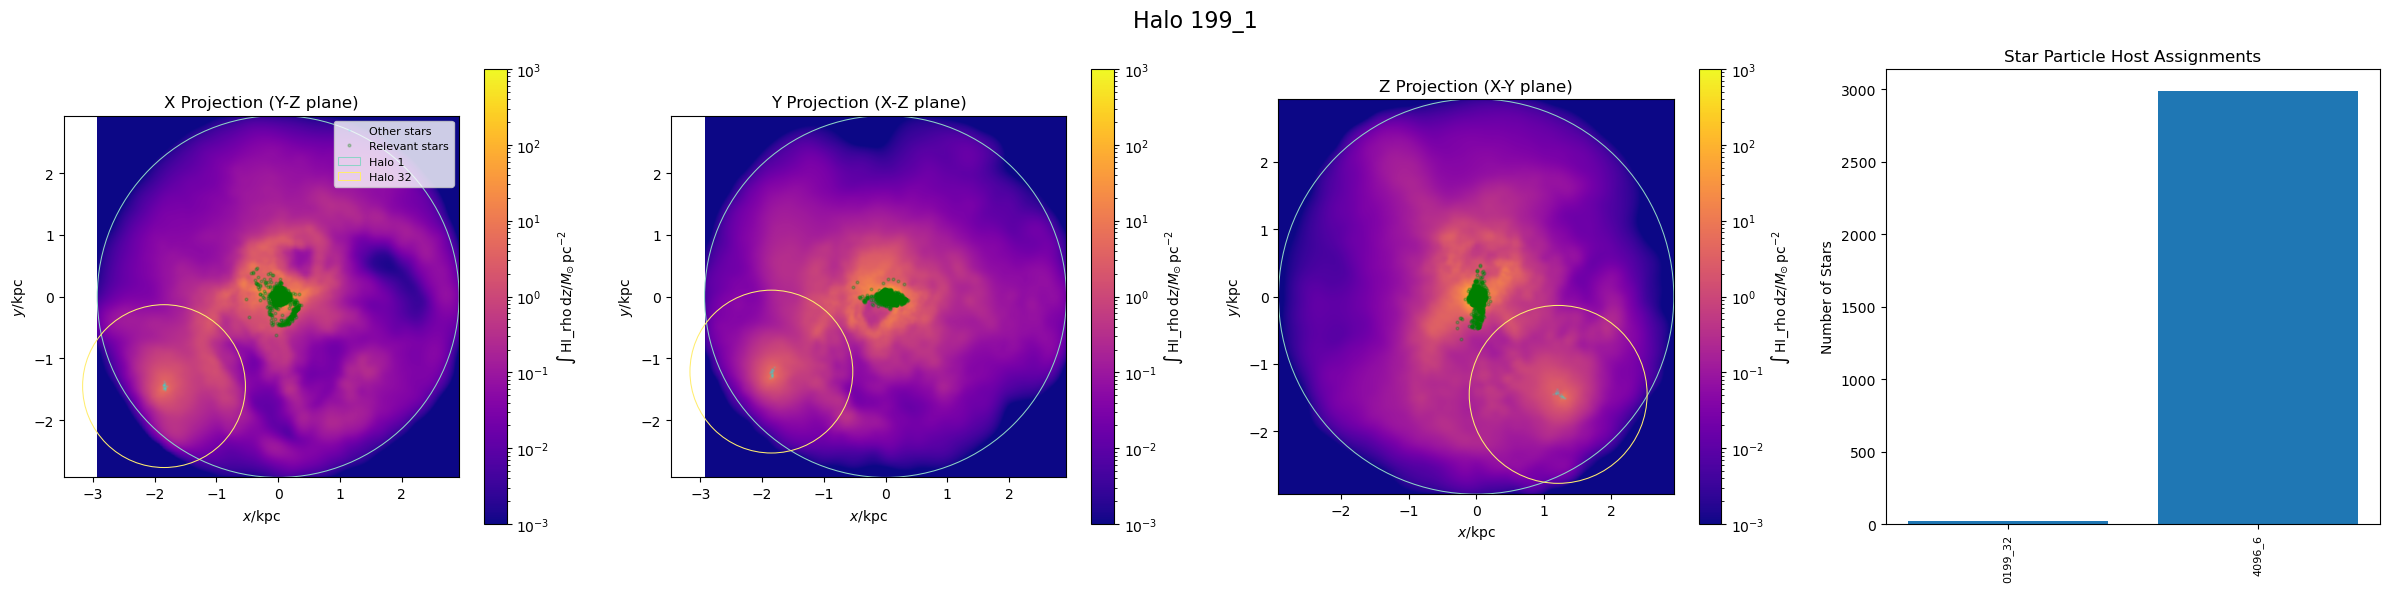

In [32]:
import tqdm.auto as tqdm

pbar = tqdm.tqdm(total=total_halos, desc='Processing halos')
for i, timestep in enumerate(all_timesteps):
    # print(timestep.extension[-6:])
    timestep = timestep.extension[-6:]
    halos = halos_stars_dict[timestep]
    print('\nFound {} halos in timestep {}'.format(len(halos), timestep))
    s = pynbody.load(sim_base + sims + '.' + timestep)
    s.physical_units()

    st = int(timestep) # Which snapshot do you want to visualize these star particles at?
    if not i < 1:
        tslim = int(all_timesteps[i-1].extension[-6:])
        print('Found previous timestep:', tslim)
    else:
        tslim = 0 # What is the earliest snapshot that you want the star particles to have formed at?

    uplim = db.get_timestep("cptmarvel.4096g5HbwK1BH_bn/%" + str(st)).time_gyr
    if tslim>0:
        lowlim = db.get_timestep("cptmarvel.4096g5HbwK1BH_bn/%" + str(tslim)).time_gyr
    elif tslim == 0:
        lowlim = 0
    else:
        print ('Please rethink your lowlim value. It does not make sense.')

    for halo in halos:
        relhostid = np.array([str(st) + '_' + str(halo.halo_number)])
        print('relhostid = ', relhostid)
        # pids = partids[(np.isin(hostids,relhostid)) & (pct>lowlim) & (pct<uplim)]
        pids = partids[(np.isin(ph,halo.halo_number)) & (pct>lowlim) & (pct<uplim)]
        print ('Relevant particles:',len(pids)) # How many star particles will actually be highlighted?
        if len(pids) == 0:
            print('No relevant particles found. Skipping')
            pbar.update(1)
            continue
        # print ('Looking for: ', len(pids)) # Full number of relevant star particles in this snapshot.
                                       # Make sure you actually find all of them!
        # print(halo.all_properties)
        roughcen = halo['shrink_center']
        try:
            rad = halo['Rvir']
        except:
            rad = halo['max_radius']
        fst = HighlightParticlesMultiProjection(s,roughcen,rad=rad,
                                 haloplot=True, show_hs=True, 
                                 caption=relhostid[0],
                                 savefig=True, overwrite=True) # Have our first look
        # fst = HighlightParticles(s,roughcen,rad=15, projax='x',
        #                          haloplot=False, show_hs=True)
        # fst = HighlightParticles(s,roughcen,rad=15, projax='y',
        #                          haloplot=False, show_hs=True)
        # fst = HighlightParticles(s,roughcen,rad=15, projax='z',
        #                          haloplot=False, show_hs=True)
        pbar.update(1)
        break
    break

### Old Again

In [46]:
# Print out the main progenitors of this halo in case you end up needing to back up and center on it
# at an earlier snapshot (e.g., if it has already disrupted)
if ishalo == 0:
    thisid = 1
else:
    thisid = ishalo
hti,sti = sim[dbind][thisid].calculate_for_progenitors('halo_number()','step_path()')
for sv,hv in zip(sti,hti):
    print (sv,hv)

cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096 1
cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.003968 1
cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.003840 1
cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.003712 1
cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.003636 1
cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.003584 1
cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.003456 1
cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.003328 1
cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.003245 1
cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.003200 1
cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.003072 1
cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.002944 1
cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.002816 1
cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.002688 1
cptmar

### What follows is a hodgepodge of methods for spotting errant star particles and identifying their correct hosts + a cell that saves a list of particles to a numpy file as an input for FixHostIDs. I typically cycle through these in no particular order.

In [20]:
# Less necessary for the MMs, but helpful for larger sims: will ding when it hits this point, as this 
# is where the standard initial pass ends and that can take a while
wave = np.sin(1.4*np.pi*400*np.arange(0.5*10000)/10000)
Audio(wave, rate=10000, autoplay=True)

In [14]:
print (alskdfj) # This is really just a silly way of adding a break

NameError: name 'alskdfj' is not defined

12244 relevant stars found
Found 16 halos with stars
[<Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_1' | NDM=2673328 Nstar=205466 Ngas=341360>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_2' | NDM=1809471 Nstar=55462 Ngas=531508>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_4' | NDM=1624243 Nstar=31452 Ngas=367221>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_5' | NDM=1257579 Nstar=45841 Ngas=116308>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_6' | NDM=1179048 Nstar=43645 Ngas=134861>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_7' | NDM=897819 Nstar=4199 Ngas=88876>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_8' | NDM=279916 Nstar=10015 Ngas=536699>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_

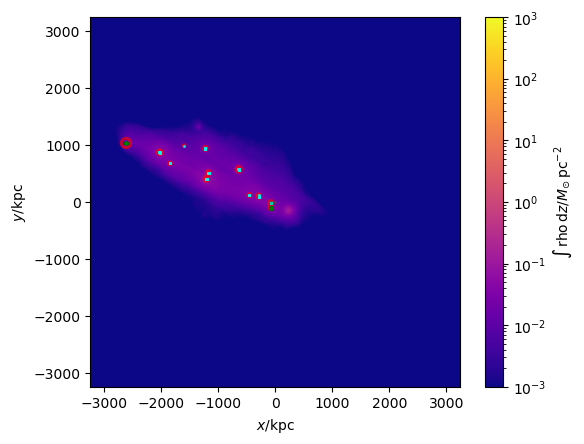

0000_0 37
0001_0 91
0002_0 90
0003_0 35
0004_0 223
0005_0 157
0006_0 525
0008_0 435
0010_0 537
0011_0 19
0012_0 454
0013_0 204
0014_0 385
0015_0 702
0016_0 34
0017_0 588
0018_0 563
0019_0 114
0020_0 353
0021_0 294
0023_0 72
0024_0 404
0025_0 336
0026_0 390
0027_0 170
0028_0 182
0029_0 325
0030_0 366
0031_0 361
0032_0 330
0033_0 142
0034_0 260
0035_0 393
0036_0 455
0037_0 184
0038_0 311
0039_0 498
0040_0 552
0041_0 673
0291_12 4
0384_14 233
0384_8 2454
0384_9 7531
0512_23 182
1280_17 1064
1408_158 39
1543_12 8754
1920_17 294
2048_29 295
3840_107 23
4096_1 187619
4096_10 11823
4096_11 1953
4096_13 1166
4096_14 23
4096_16 67
4096_167 24
4096_2 51963
4096_27 14
4096_4 20570
4096_455 157
4096_5 41955
4096_6 41230
4096_7 4190
4096_8 614


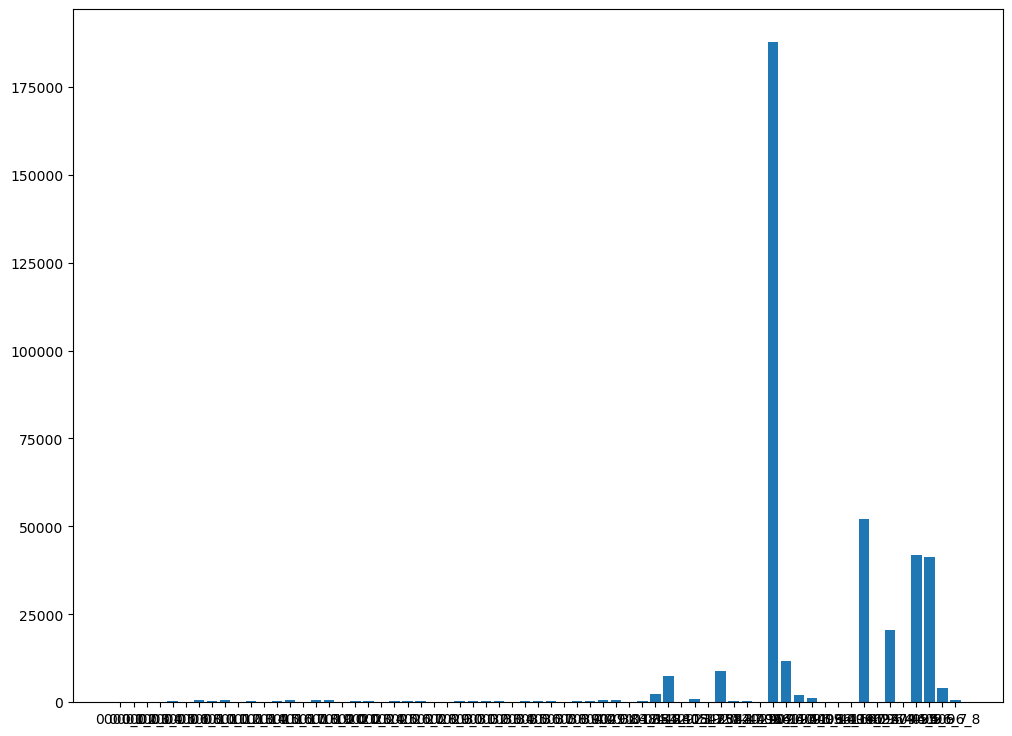

likely host: 4096_1
12244 relevant stars found
Found 16 halos with stars
[<Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_1' | NDM=2673328 Nstar=205466 Ngas=341360>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_2' | NDM=1809471 Nstar=55462 Ngas=531508>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_4' | NDM=1624243 Nstar=31452 Ngas=367221>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_5' | NDM=1257579 Nstar=45841 Ngas=116308>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_6' | NDM=1179048 Nstar=43645 Ngas=134861>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_7' | NDM=897819 Nstar=4199 Ngas=88876>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_8' | NDM=279916 Nstar=10015 Ngas=536699>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5

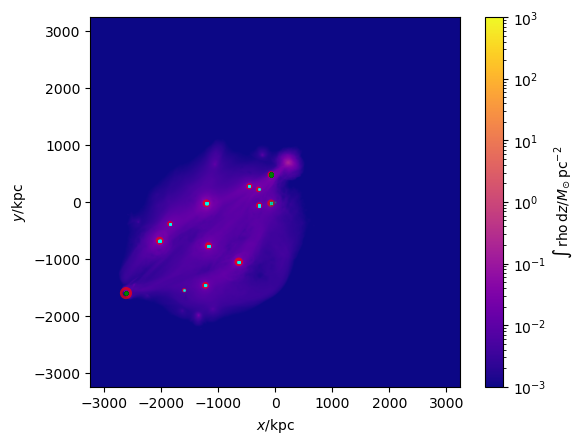

0000_0 37
0001_0 91
0002_0 90
0003_0 35
0004_0 223
0005_0 157
0006_0 525
0008_0 435
0010_0 537
0011_0 19
0012_0 454
0013_0 204
0014_0 385
0015_0 702
0016_0 34
0017_0 588
0018_0 563
0019_0 114
0020_0 353
0021_0 294
0023_0 72
0024_0 404
0025_0 336
0026_0 390
0027_0 170
0028_0 182
0029_0 325
0030_0 366
0031_0 361
0032_0 330
0033_0 142
0034_0 260
0035_0 393
0036_0 455
0037_0 184
0038_0 311
0039_0 498
0040_0 552
0041_0 673
0291_12 4
0384_14 233
0384_8 2454
0384_9 7531
0512_23 182
1280_17 1064
1408_158 39
1543_12 8754
1920_17 294
2048_29 295
3840_107 23
4096_1 187619
4096_10 11823
4096_11 1953
4096_13 1166
4096_14 23
4096_16 67
4096_167 24
4096_2 51963
4096_27 14
4096_4 20570
4096_455 157
4096_5 41955
4096_6 41230
4096_7 4190
4096_8 614


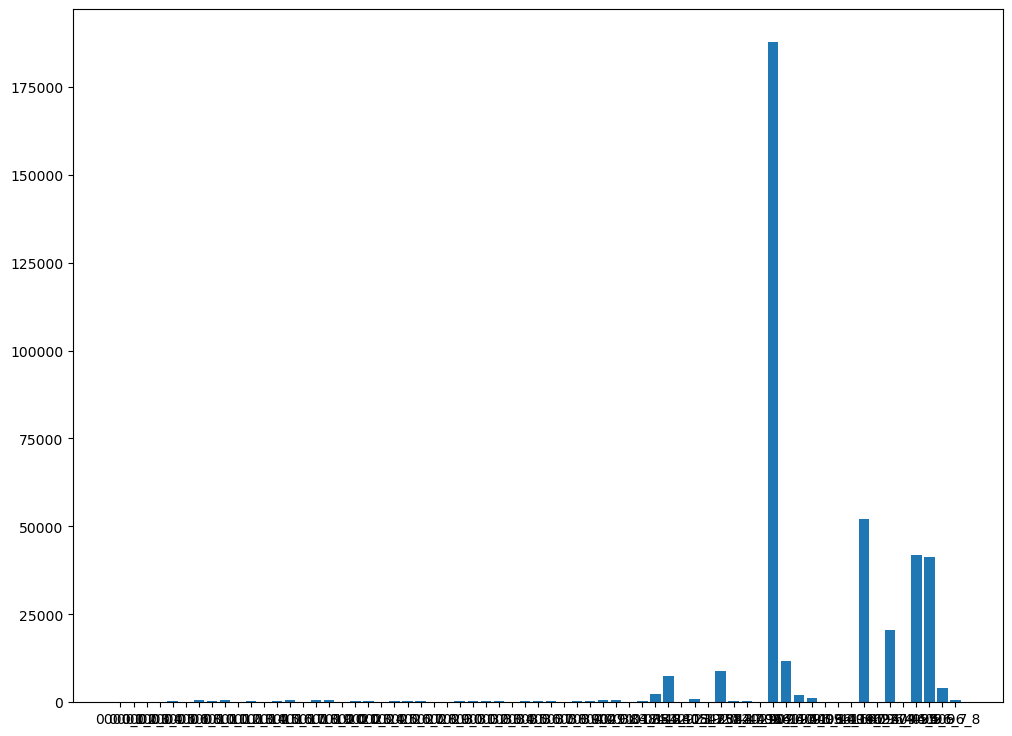

likely host: 4096_1
12244 relevant stars found
Found 16 halos with stars
[<Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_1' | NDM=2673328 Nstar=205466 Ngas=341360>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_2' | NDM=1809471 Nstar=55462 Ngas=531508>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_4' | NDM=1624243 Nstar=31452 Ngas=367221>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_5' | NDM=1257579 Nstar=45841 Ngas=116308>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_6' | NDM=1179048 Nstar=43645 Ngas=134861>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_7' | NDM=897819 Nstar=4199 Ngas=88876>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_8' | NDM=279916 Nstar=10015 Ngas=536699>, <Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5

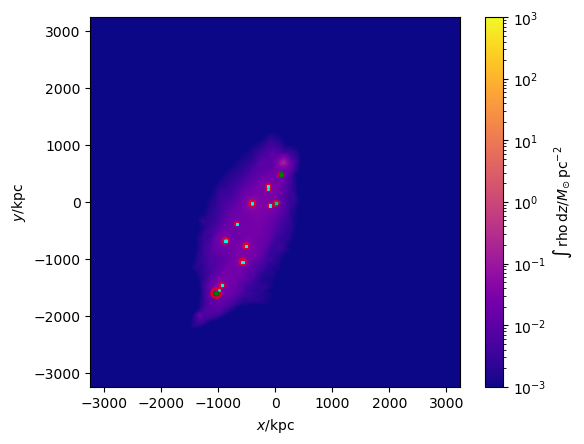

0000_0 37
0001_0 91
0002_0 90
0003_0 35
0004_0 223
0005_0 157
0006_0 525
0008_0 435
0010_0 537
0011_0 19
0012_0 454
0013_0 204
0014_0 385
0015_0 702
0016_0 34
0017_0 588
0018_0 563
0019_0 114
0020_0 353
0021_0 294
0023_0 72
0024_0 404
0025_0 336
0026_0 390
0027_0 170
0028_0 182
0029_0 325
0030_0 366
0031_0 361
0032_0 330
0033_0 142
0034_0 260
0035_0 393
0036_0 455
0037_0 184
0038_0 311
0039_0 498
0040_0 552
0041_0 673
0291_12 4
0384_14 233
0384_8 2454
0384_9 7531
0512_23 182
1280_17 1064
1408_158 39
1543_12 8754
1920_17 294
2048_29 295
3840_107 23
4096_1 187619
4096_10 11823
4096_11 1953
4096_13 1166
4096_14 23
4096_16 67
4096_167 24
4096_2 51963
4096_27 14
4096_4 20570
4096_455 157
4096_5 41955
4096_6 41230
4096_7 4190
4096_8 614


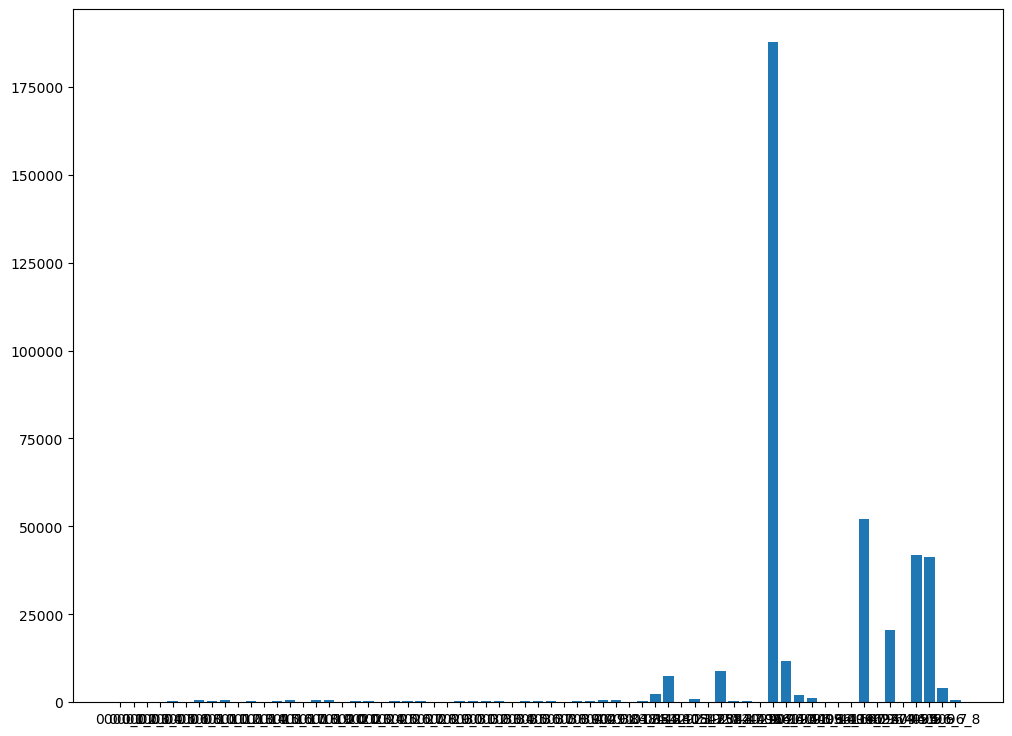

likely host: 4096_1


In [24]:
# Look at the region from multiple angles to see if you can spot any star particles that look out of place.
# Adjust galrad as necessary. This also dings when it is done
galrad = valout # 10.5
fst = HighlightParticles(s,roughcen,rad=galrad,projax='y',show_hs=True)
fst = HighlightParticles(s,roughcen,rad=galrad,projax='x',show_hs=True)
fst = HighlightParticles(s,roughcen,rad=galrad,projax='z',show_hs=True)
wave = np.sin(1.4*np.pi*400*np.arange(0.5*10000)/10000)
Audio(wave, rate=10000, autoplay=True)

In [22]:
inst = np.array([]) # A list to contain the IDs of the relevant particles that you've found

46 stars still outstanding
1 relevant stars found


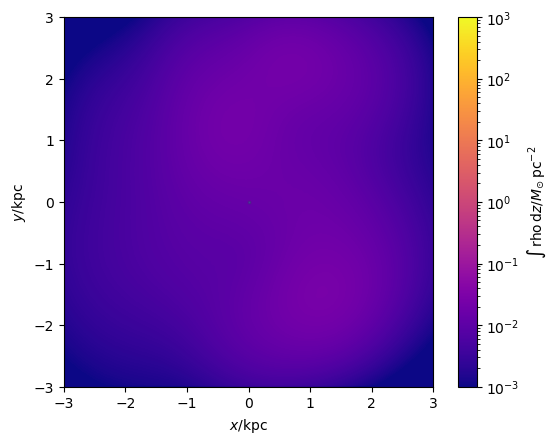

4096_166 1


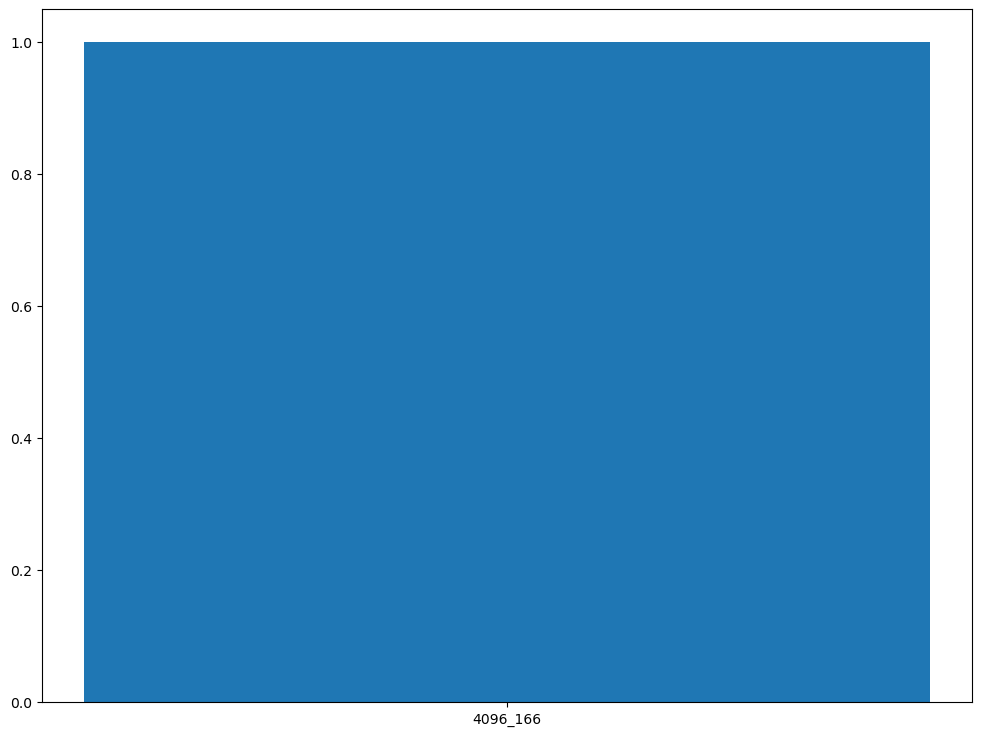

likely host: 4096_166


In [25]:
# Check off the particles you've found...
inst = np.concatenate((inst,fst)) # Put the particles whose IDs are currently stored in fst into your 
                                  # list of particles that you've found. 

46 stars still outstanding
1 relevant stars found


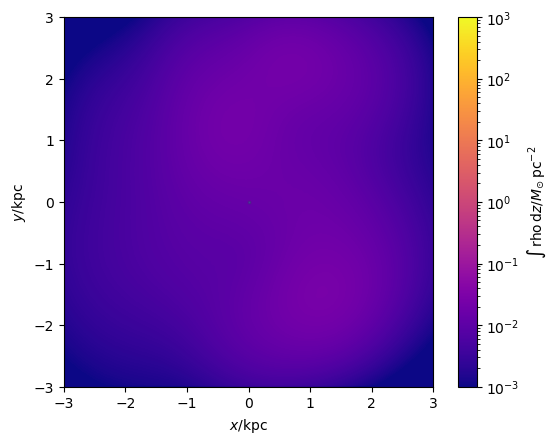

4096_166 1


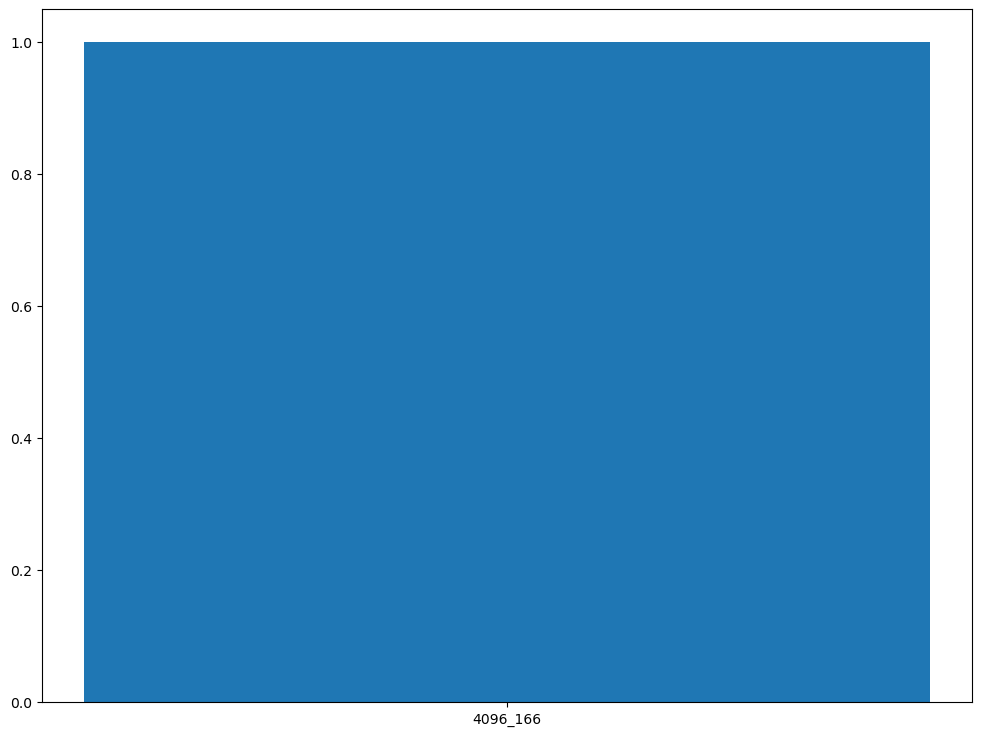

likely host: 4096_166


In [26]:
#...and center on different particles until you've found all of them. Re-run cell as necessary in combination with 
# those below it (and the one above it). Another one that dings.
stnotarr = pids[~np.isin(pids,inst)] # Make a list of relevant particles you haven't yet found
print (str(len(stnotarr))+' stars still outstanding')
roughcen = s.s['pos'][s.s['iord']==stnotarr[int(math.floor(len(stnotarr)/2))]][0] # center on one of these errant particles
fst = HighlightParticles(s,roughcen,rad=3,projax='y',show_hs=True) 
wave = np.sin(1.4*np.pi*400*np.arange(0.5*10000)/10000)
Audio(wave, rate=10000, autoplay=True)

In [27]:
# Are there any halos near our current center? Very occasionally helpful if a small halo formed a few stars but they were stripped
# before the next snapshot. It will print every halo within tol kpc along with its mass to help you sanity check. In my 
# experience, this is almost never helpful, but it's worth a shot if the previous methods have failed.
print (roughcen)
tol = 5 # distance in kpc out to which you want to search
curmin = 1000
for i in range(1,len(sim[dbind].halos[:])+1):
    curh = sim[dbind][i].finder_id
    dfh = np.linalg.norm(np.median(h[curh]['pos'],axis=0)-roughcen)
    if dfh<=tol:
        print (i,curh,dfh,np.log10(np.sum(h[curh]['mass'])))
    if dfh<curmin:
        curmin = dfh
print ('Best:',curmin)

[ 5927.27474873 -1919.24721004  2279.41181512]


/Users/anna/anaconda3/envs/pyn/lib/python3.11/site-packages/pynbody/halo/__init__.py:274: RuntimeWarning: Accessing multiple halos may be more efficient if you call load_all() on the halo catalogue
  warnings.warn("Accessing multiple halos may be more efficient if you call load_all() on the "


Best: 5.382194566260222


### Write out

In [ ]:
mask = hostids == '4096_4'
partids_masked = partids[mask]

In [111]:
print(len(partids_masked), 'particles found with host ID 1920_17')
print(len(fst), 'particles found in the highlighted region')

295 particles found with host ID 1920_17
295 particles found in the highlighted region


In [63]:
fst

SimArray([89721269, 89721308, 89721347, 89721348, 89721349, 89721368,
          89721369, 89721370, 89721381, 89721382, 89721383, 89721388,
          89721394, 89721424, 89721433, 89721441, 89721448, 89721449,
          89721450, 89721462, 89721463, 89721464, 89721465, 89721466,
          89721467, 89721468, 89721469, 89721470, 89721471, 89721472,
          89721473, 89721474, 89721475, 89721479, 89721480, 89721481,
          89721487, 89721488, 89721489, 89721490, 89721500, 89721501,
          89721502, 89721512, 89721513, 89721514, 89721515, 89721516,
          89721517, 89721526, 89721527, 89721528, 89721529, 89721538,
          89721539, 89721540, 89721541, 89721542, 89721543, 89721555,
          89721584, 89721585, 89721586, 89721587, 89721588, 89721589,
          89721635, 89721636, 89721638, 89721639, 89721640, 89721653,
          89721654, 89721678, 89721679, 89721680, 89721698, 89721699,
          89721715, 89721716, 89721733, 89721734, 89721745, 89721746,
          89721747, 

In [238]:
# Save a list of star particle IDs to a numpy array so that you can use FixHostIDs to re-assign them
# Because you may end up with multiple lists of star particles that should be re-assigned to the same host,
# we'll check how many numpy files you already have in this format for this host and increment the file name to avoid
# overwriting a previous list (e.g., r492_0672_3_2.npy is the second list of star particles that should be re-assigned to
# host_ID '0672_3' in simulation r492).

nh = '1280_17' # The host_ID you want to reassign them to

hs = glob.glob(odir+sims+'_'+nh+'_*.npy')

maxind = 0
if len(hs)>0:
    for i in hs:
        val = int(str(i).split('_')[-1].split('.')[-2])
        if val>maxind:
            maxind = val
np.save(odir+sims+'_'+nh+'_'+str(maxind+1)+'.npy',fst)

In [239]:
hs

['/home/selvani/MAP/pynbody/stellarhalo_trace_aw/cptmarvel.cosmo25cmb.4096g5HbwK1BH_1280_17_1.npy']

## 